![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [210]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-project3-datasets/cities.csv
/kaggle/input/sf-project3-datasets/cuisine_types.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [211]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [212]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [ ]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [ ]:
# загружаем датасеты с дополнительной информацией. Возможно, она окажется полезной.
df_cuisine_types = pd.read_csv('/kaggle/input/sf-project3-datasets/cuisine_types.csv')
df_cities = pd.read_csv('/kaggle/input/sf-project3-datasets/cities.csv')

In [ ]:
df_cuisine_types.head()

In [ ]:
df_cities.head()

In [ ]:
df_train.info()

In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
df.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [ ]:
# Создадим столбец
#data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [ ]:
#data['Number_of_Reviews_isNAN']

In [ ]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
#data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [ ]:
df.nunique(dropna=False)

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [ ]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [ ]:
#data.head(5)

In [ ]:
def look_at(row):
    print('Уникальных значений (включая Nan): ', df[row].nunique(dropna=False),'\n')
    print('Value_counts:')
    print(df[row].value_counts(),'\n')
    print('Количество Nan:')
    print(df[row].isna().value_counts())
    return

#### Признак "Restaurant_id".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('Restaurant_id')

In [ ]:
# Посмотрим на рестораны с одинаковым id
df[df['Restaurant_id'] == 'id_871']

In [ ]:
df[df['Restaurant_id'] == 'id_436']

Во-первых, не похоже, что рестораны с одинаковым id принадлежат к одной сети из-за разных кухонь.  
Во-вторых, очевидна взаимосвязь между id и Ranking в df_train.

In [ ]:
df['restaurant_id_num'] = df['Restaurant_id'].apply(lambda x: int(x.replace('id_','')))
df[['restaurant_id_num','Ranking']].corr()

In [ ]:
df_train['restaurant_id_num'] = df_train['Restaurant_id'].apply(lambda x: int(x.replace('id_','')))
df_train[['restaurant_id_num','Ranking']].corr()

In [ ]:
df.drop('restaurant_id_num', axis=1, inplace=True)
df_train.drop('restaurant_id_num', axis=1, inplace=True)

#### Признак "City".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('City')

In [ ]:
# Посмострим, совпадают ли города в df_train и df_test
df_train['City'].value_counts().index.sort_values() == df_train['City'].value_counts().index.sort_values()

City - категориальный признак, состоящий из 31 города Европы.  
Пропусков нет.  
Т.к. городов не много, я посмотрел на каждый, нашел ошибку в названии города Porto.  
Кроме того, я составил небольшой дополнительный датасет по этим городам.

In [ ]:
df['City'] = df['City'].replace('Oporto','Porto')

In [ ]:
df = pd.merge(df, df_cities, how = 'left', on = 'City')
df.head()

In [ ]:
# Посчитаем количество ресторанов в датасете для каждого города
rest_count = pd.DataFrame(df['City'].value_counts()).reset_index()
rest_count.columns = ['City','rest_count_in_city']
df = pd.merge(df, rest_count, how = 'left', on = 'City')
df.head()

One-Hot Encoding для City я применю в конце, чтобы не загромождать раньше времени таблицу

#### Признак "Cuisine Style".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('Cuisine Style')

Cuisine Style - сложносоставной категориальный признак.
Достаточно много пропущенных значений, я заменю их на unknown.

In [ ]:
df['Cuisine Style'] = df['Cuisine Style'].fillna("['unknown']")

In [ ]:
type(df['Cuisine Style'][0])

In [ ]:
# Т.к. значения признака  хоть и принадлежат к классу Srting, но имеют формат списка.
# Чтобы спарсить значения воспользуюсь встроенной функцией eval(). В данном случае ее применение безопасно
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x))

In [ ]:
cuisines = df.explode('Cuisine Style')['Cuisine Style'].value_counts()
cuisines

Кухонь всего 126 (включая unknown), можно посмотреть на них всех

In [ ]:
def print_full(df):
    ''' Функция для отображения всех строк DataFrame '''
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_rows')

In [ ]:
print_full(cuisines)

In [ ]:
# Я вручную сгруппировал кухни по своему усмотрению, чтобы в дальнейшем применить multilabel encoding
df_cuisine_types

In [ ]:
# добавим столбец с типами предлагаемых кухонь
df['idx'] = df.index
df_tmp = pd.merge(df.explode('Cuisine Style')[['idx','Cuisine Style']], df_cuisine_types, on='Cuisine Style',how='left')
df_tmp.drop_duplicates(['idx','cuisine_type'], inplace=True)
df_tmp = df_tmp.groupby('idx')['cuisine_type'].apply(list).reset_index()
df = pd.merge(df, df_tmp, on='idx', how='left')
df.drop(['idx'], axis=1, inplace=True)
df.head()

In [ ]:
# Также добавим признак количество предлагаемых кухонь
df['cuisine_count'] = df['Cuisine Style'].str.len()
df.head()

In [ ]:
# Сейчас unknown считается за одну предлагаемую кухню. Исправим это.
df['missed_cuisine']=df['Cuisine Style'].apply(lambda x: 1 if x == ['unknown'] else 0)
df['cuisine_count'] = (1-df['missed_cuisine'])*df['cuisine_count']
df.head()

#### Признак "Ranking".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('Ranking')

In [ ]:
df[df['Ranking'] == 93]['City'].value_counts()

In [ ]:
# посмотрим на топ 10 городов
plt.rcParams['figure.figsize'] = (14,10)
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [ ]:
# Нет информации обо всех рангах для каждого города, вероятно из-за того, что не все растораны города присутствуют датасете TripAdvisor
print(df[df['City'] == 'London']['Ranking'].value_counts().index.sort_values(ascending = True)[0:10])
print(df[df['City'] == 'Madrid']['Ranking'].value_counts().index.sort_values(ascending = True)[0:10])
print(df[df['City'] == 'Berlin']['Ranking'].value_counts().index.sort_values(ascending = True)[0:10])

In [ ]:
# Естественно сильно отличается последний ранг с общим количеством ресторанов в городе
print(df['Ranking'][df['City'] == 'London'].max())
print(len(df['Ranking'][df['City'] == 'London']))

Получается, что Ranking распределен равномерно, просто в больших городах больше ресторанов, из-за мы этого для каждого города своя верхняя граница ранга.
Для объективности картины нужно нормировать ранг.  
Я нормирую ранг двумя разными способами, посмотрим, какой из них даст лучшую оценку. А также выясним, есть ли аномальные значения.

In [ ]:
# найдем средний ранг в каждом городе
mean_rank_in_city = df.groupby('City')['Ranking'].mean().reset_index()
mean_rank_in_city.rename(columns = {'Ranking':'mean_rank'}, inplace=True)

# добавим эту информацию в наш датасет
df = pd.merge(df,mean_rank_in_city, on='City',how='left')

# идея нормирования в данном случае такая: новый ранг ресторана на 1 месте равен единице, а новый ранг ресторана на последнем месте стремится к 0.
df['norm_rank_mean'] = (df['Ranking']-df['mean_rank'])/df['mean_rank']
df.head()

In [ ]:
# посмотрим распределение нормированного ранга
plt.rcParams['figure.figsize'] = (14,10)
for x in (df['City'].value_counts()).index:
    df['norm_rank_mean'][df['City'] == x].hist(bins=100)
plt.show()

In [ ]:
# найдем максимальный ранг в каждом городе
max_rank_in_city = df.groupby(df['City'])['Ranking'].max().reset_index()
max_rank_in_city.rename(columns = {'Ranking':'max_rank_in_city'}, inplace=True)

# добавим эту информацию в наш датасет
df = pd.merge(df,max_rank_in_city, on='City',how='left')

# идея нормирования в данном случае такая: новый ранг ресторана на 1 месте равен единице, а новый ранг ресторана на последнем месте стремится к 0.
df['norm_rank_max'] = (df['max_rank_in_city']+1-df['Ranking'])/df['max_rank_in_city']
df.head()

#### Признак "Price Range".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('Price Range')

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [ ]:
# заменим категориальные признаки на ординальные.
# Пропуски заменим на среднюю цену, т.к. это самый популярный вариант
# Чтобы не потерялась информация о пропусках, предварительно создадим отдельный признак

df['missed_price_range'] = pd.isna(df['Price Range']).astype('uint8')

df['Price Range'].fillna(2, inplace=True)

def price_range_ord(cell):
    if type(cell) == str:
        cell = cell.replace('$$$$', '3')
        cell = cell.replace('$$ - $$$', '2')
        cell = cell.replace('$', '1')
        cell = int(cell)
    return cell

df['Price Range'] = df['Price Range'].apply(price_range_ord)

In [ ]:
print(df['Price Range'].value_counts())
print(df['missed_price_range'].value_counts())

In [ ]:
df.head()

#### Признак "Reviews".
Обработку этого признака я поставил перед Number of Reviews, чтобы заполнить пропуски в последнем.

In [ ]:
# Посмотрим на признак в первом приближении
look_at('Reviews')

Reviews - сложносоставной качественный признак. Значения признака имеют тип string, но выглядят как list с текстом и датами. Эту информацию нужно извлечь.  
Пропуски заменим на '[[], []]'

In [ ]:
df['Reviews'].fillna('[[], []]', inplace=True)

In [ ]:
df[(df['Number of Reviews']>0)&(df['Reviews'] == '[[], []]')]

In [ ]:
# довольно много строк, где указано количество отзывов, но отзывов нет. Сохраним эту информацию
df['missed_reviews'] = df[(df['Number of Reviews']>0)&(df['Reviews'] == '[[], []]')]['Reviews'].apply(lambda x: 1)
df['missed_reviews'].fillna(0, inplace=True)

In [ ]:
df['missed_reviews'].value_counts()

In [ ]:
# вытащим информацию из столбца Reviews и разложим по отдельным признакам текст отзыва и дату отзыва
nan = None
df['reviews_text'] = df['Reviews'].apply(lambda x: eval(x)[0])
df['reviews_date'] = df['Reviews'].apply(lambda x: eval(x)[1])
df.head()

In [ ]:
def get_date(cell):
    ''' Функция для обработки признака reviews_date.
    Преобразует string в DateTimeIndex '''
    if len(cell):
        cell = pd.to_datetime(cell, errors='coerce', format='%m/%d/%Y')
    return cell

In [ ]:
df['reviews_date'] = df['reviews_date'].apply(get_date)

In [ ]:
def time_delta(cell):
    ''' Функция для обработки признака reviews_date.
    Возвращает разницу в днях между датами отзывов.
    Если отзыв всего один или их нет, возвращает -1'''
    if len(cell)<2:
        return -1
    return np.abs((cell[0] - cell[1]).days)

In [ ]:
df['reviews_date_delta'] = df['reviews_date'].apply(time_delta)

df.head()

In [ ]:
df['reviews_date_delta'].value_counts()

In [ ]:
df['reviews_date_delta'].hist(bins=100)

In [ ]:
df[df['reviews_date_delta']>1000]['reviews_date_delta'].hist(bins=100)

In [ ]:
# Действительно, на сайте по этому ресторану имеются всего 2 отзыва с разницей почти в 10 лет.
df[df['reviews_date_delta'] == df['reviews_date_delta'].max()]['URL_TA'].values

In [ ]:
def fresh_review(cell):
    ''' Функция возвращает дату самого свежего отзыва в UNIX-формате
    Если отзыва нет, то возвращается 0'''
    if len(cell) == 0:
        return pd.to_datetime(0, unit='s').timestamp()
    if len(cell) == 1:
        return cell[0].timestamp()
    return cell.max().timestamp()

In [ ]:
df['fresh_review_date'] = df['reviews_date'].apply(fresh_review)

In [ ]:
df.head()

#### Признак "Number of Reviews".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('Number of Reviews')

Number of Reviews - числовой признак.  
Содержит около 6% пропусков.  
Посмотрим на распределение признака.

In [ ]:
df[df['Number of Reviews']==1]['Number of Reviews'].value_counts()

Странно, что нет ресторанов с одним отзывом..

In [ ]:
df[df['Number of Reviews'].isna()]

In [ ]:
# Очевидно, есть ошибка в данных, когда отзывы есть, а их количества нет.
# Заменим пропущенные значения количеством отзывов из столбца Reviews.

df['Number of Reviews'].fillna(df['reviews_text'].apply(len), inplace=True)

In [ ]:
df['Number of Reviews'].hist(bins=100)

In [ ]:
df[df['Number of Reviews']>1000]['Number of Reviews'].hist(bins=100)

#### Признак "ID_TA".

In [ ]:
# Посмотрим на признак в первом приближении
look_at('ID_TA')

In [ ]:
df['ID_TA'].value_counts()

In [ ]:
# Посмотрим на рестораны с одинаковым id
df[df['ID_TA'].duplicated(keep=False)].sort_values(by=['ID_TA'])

Видим, что 36 строк дублированы с небольшим отклонением Ranking.  
По условию задачи строки удалять нельзя, поэтому ничего тут делать не будем, строк очень мало относительно выборки.

In [ ]:
df['ID_TA_num'] = df['ID_TA'].apply(lambda x: int(x.replace('d','')))
df[['ID_TA_num','Ranking','Rating']].corr()

Явной зависимости ID_TA от ранга и рейтинга нет, в отличие от Restarant_id.  
Я предполагаю, что ID_TA линейно растет относительно времени занесения ресторана в БД TA.  
Возможно есть какая-либо взаимосвязь типа "раньше оценки были другие.." 

In [ ]:
# Итого наш дополненный датасет
df.sample(5)

In [ ]:
df.info()

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [213]:
# на всякий случай, заново подгружаем данные
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')


data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [214]:
def price_range_ord(cell):
    ''' Функция меняет string значения ординального признака Price Range на целочисленные '''
    if type(cell) == str:
        cell = cell.replace('$$$$', '3')
        cell = cell.replace('$$ - $$$', '2')
        cell = cell.replace('$', '1')
        cell = int(cell)
    return cell

def get_date(cell):
    ''' Функция для обработки признака reviews_date.
    Преобразует string в DateTimeIndex '''
    if len(cell):
        cell = pd.to_datetime(cell, errors='coerce', format='%m/%d/%Y')
    return cell

def time_delta(cell):
    ''' Функция для обработки признака reviews_date.
    Возвращает разницу в днях между датами отзывов.
    Если отзыв всего один или их нет, возвращает -1'''
    if len(cell)<2:
        return -1
    return np.abs((cell[0] - cell[1]).days)

def fresh_review(cell):
    ''' Функция возвращает дату самого свежего отзыва в UNIX-формате
    Если отзыва нет, то возвращается 0'''
    if len(cell) == 0:
        return pd.to_datetime(0, unit='s').timestamp()
    if len(cell) == 1:
        return cell[0].timestamp()
    return cell.max().timestamp()

nan = None

def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # исправляем ошибку в названии города
    df_output['City'] = df_output['City'].replace('Oporto','Porto')
    # подгружаем дополнительные признаки, связанные с типами кухонь и с городами
    df_cuisine_types = pd.read_csv('/kaggle/input/sf-project3-datasets/cuisine_types.csv')
    df_cities = pd.read_csv('/kaggle/input/sf-project3-datasets/cities.csv')
    df_output = pd.merge(df_output, df_cities, how = 'left', on = 'City')

    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Cuisine Style'].fillna("['unknown']", inplace=True)
     # Чтобы не потерялась информация о пропусках, предварительно создадим отдельный признак
    df_output['missed_price_range'] = pd.isna(df_output['Price Range']).astype('uint8')
    df_output['Price Range'].fillna(2, inplace=True)
    df_output['Reviews'].fillna('[[], []]', inplace=True)

    
    
    # ################### 3. Encoding ############################################################## 
    # Чтобы спарсить значения воспользуюсь встроенной функцией eval().
    # В данном случае ее применение безопасно
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: eval(x))
    # вытащим информацию из столбца Reviews и разложим по отдельным признакам текст отзыва и дату отзыва
    nan = None
    df_output['reviews_text'] = df_output['Reviews'].apply(lambda x: eval(x)[0])
    df_output['reviews_date'] = df_output['Reviews'].apply(lambda x: eval(x)[1])
    df_output['reviews_date'] = df_output['reviews_date'].apply(get_date)
    
    
    
    # ################### 4. Feature Engineering ####################################################
    
    # ########## City ###########
    # Количество ресторанов в датасете для каждого города
    rest_count = pd.DataFrame(df_output['City'].value_counts()).reset_index()
    rest_count.columns = ['City','rest_count_in_city']
    df_output = pd.merge(df_output, rest_count, how = 'left', on = 'City')
    
    
    # ########## Cuisine Style ###########
    # добавим столбец с типами предлагаемых кухонь
    df_output['idx'] = df_output.index
    df_tmp = pd.merge(df_output.explode('Cuisine Style')[['idx','Cuisine Style']], df_cuisine_types, on='Cuisine Style',how='left')
    df_tmp.drop_duplicates(['idx','cuisine_type'], inplace=True)
    df_tmp = df_tmp.groupby('idx')['cuisine_type'].apply(list).reset_index()
    df_output = pd.merge(df_output, df_tmp, on='idx', how='left')
    df_output.drop(['idx'], axis=1, inplace=True)
    # Также добавим признак количество предлагаемых кухонь
    df_output['cuisine_count'] = df_output['Cuisine Style'].str.len()
    # Сейчас unknown считается за одну предлагаемую кухню. Исправим это.
    # А также добавим отдельный признак на отстутствующие данные по Cuisine Style
    df_output['missed_cuisine'] = df_output['Cuisine Style'].apply(lambda x: 1 if x == ['unknown'] else 0)
    df_output['cuisine_count'] = (1 - df_output['missed_cuisine'])*df_output['cuisine_count']
    
    
    # ########## Ranking ###########
    # найдем средний ранг в каждом городе
    mean_rank_in_city = df_output.groupby('City')['Ranking'].mean().reset_index()
    mean_rank_in_city.rename(columns = {'Ranking':'mean_rank_in_city'}, inplace=True)
    # добавим эту информацию в наш датасет
    df_output = pd.merge(df_output,mean_rank_in_city, on='City',how='left')
    # нормируем ранг ресторанов относительно города, в которм они находятся
    df_output['norm_rank_mean'] = (df_output['Ranking'] - df_output['mean_rank_in_city'])/df_output['mean_rank_in_city']
    # найдем максимальный ранг в каждом городе
    max_rank_in_city = df_output.groupby('City')['Ranking'].max().reset_index()
    max_rank_in_city.rename(columns = {'Ranking':'max_rank_in_city'}, inplace=True)
    # добавим эту информацию в наш датасет
    df_output = pd.merge(df_output,max_rank_in_city, on='City',how='left')
    # идея нормирования в данном случае такая: новый ранг ресторана на 1 месте равен единице, а новый ранг ресторана на последнем месте стремится к 0.
    df_output['norm_rank_max'] = (df_output['max_rank_in_city'] + 1 - df_output['Ranking'])/df_output['max_rank_in_city']
    
    
    # ########## Price Range ###########
    # заменим категориальные признаки на ординальные.
    df_output['Price Range'] = df_output['Price Range'].apply(price_range_ord)
    
    
    # ########## Reviews ###########
    # довольно много строк, где указано количество отзывов, но отзывов нет. Сохраним эту информацию
    df_output['missed_reviews'] = df_output[(df_output['Number of Reviews']>0)&(df_output['Reviews'] == '[[], []]')]['Reviews'].apply(lambda x: 1)
    df_output['missed_reviews'].fillna(0, inplace=True)
    # добавим информацию о разнице между датами отзывов
    df_output['reviews_date_delta'] = df_output['reviews_date'].apply(time_delta)
    # добавим информацию о дате последнего отзыва о каждом из ресторанов в UNIX-формате
    df_output['fresh_review_date'] = df_output['reviews_date'].apply(fresh_review)
    
    
    # ########## Number of Reviews ###########
    # Очевидно, есть ошибка в данных, когда отзывы есть, а их количества нет.
    # Заменим пропущенные значения количеством отзывов из столбца Reviews.
    df_output['Number of Reviews'].fillna(df_output['reviews_text'].apply(len), inplace=True)
    
    
    # ########## ID_TA ###########
    # Видим, что 36 строк дублированы с небольшим отклонением Ranking.
    # По условию задачи строки удалять нельзя, поэтому ничего тут делать не будем, строк очень мало относительно выборки.
    # Явной зависимости ID_TA от ранга и рейтинга нет, в отличие от Restarant_id.
    # Я предполагаю, что ID_TA линейно растет относительно времени занесения ресторана в БД TA.
    # Возможно есть какая-либо взаимосвязь типа "раньше оценки были другие.."
    df_output['ID_TA_num'] = df_output['ID_TA'].apply(lambda x: int(x.replace('d','')))
    
    
    # ################### 5. Encoding ##############################################################     
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=['City','country'], dummy_na=True)
    # На всякий случай дополнительно сделаю dummy переменные для Price Range
    df_output = df_output.join(pd.get_dummies(df_output['Price Range']))
    # Multilabel Encoding
    mlb = MultiLabelBinarizer()
    s1 = df_output['Cuisine Style']
    s2 = df_output['cuisine_type']
    df_output = df_output.join(pd.DataFrame(mlb.fit_transform(s1),columns=mlb.classes_, index=df_output.index), rsuffix='_right')
    df_output = df_output.join(pd.DataFrame(mlb.fit_transform(s2),columns=mlb.classes_, index=df_output.index), rsuffix='_right')

    
    # ################### 6. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [215]:
df_ml = preproc_data(data)

In [216]:
df_preproc = df_ml.copy()

In [217]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 219 entries, Ranking to unknown_right
dtypes: float64(11), int64(148), uint8(60)
memory usage: 63.9 MB


In [218]:
def print_full(df):
    ''' Функция для отображения всех строк DataFrame '''
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    print(df)
    pd.reset_option('display.max_rows')
    
def display_full(df):
    ''' Функция для отображения всех строк DataFrame '''
    import pandas as pd
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')

In [ ]:
display_full(pd.DataFrame(df_preproc.columns))

In [219]:
# первая итерация ранжировала признаки по степени влияния на модель (от наименее до наиболее влиятельного)
# зафиксирую его здесь, чтобы каждый раз не перезапускать процесс обучения на полном наборе признаков
sorted_features = ['country_nan', 'City_nan', 'Polynesian', 'Caucasian',
       'New Zealand', 'Yunnan', 'Albanian', 'Native American', 'Xinjiang',
       'Burmese', 'Latvian', 'Canadian', 'Salvadoran', 'Azerbaijani',
       'Chilean', 'Minority Chinese', 'Fujian', 'Uzbek', 'Welsh',
       'Ecuadorean', 'Egyptian', 'Mongolian', 'Singaporean', 'Filipino',
       'Hawaiian', 'Cambodian', 'Romanian', 'Jamaican', 'Armenian',
       'Southwestern', 'Tibetan', 'Australian', 'Slovenian',
       'Central Asian', 'Venezuelan', 'Norwegian', 'Afghani', 'Tunisian',
       'Central American', 'Israeli', 'Georgian', 'Croatian', 'Colombian',
       'Caribbean', 'Indonesian', 'Russian', 'Ukrainian', 'Bangladeshi',
       'Sri Lankan', 'Persian', 'Kosher', 'Peruvian', 'City_Ljubljana',
       'Arabic', 'Argentinean', 'Cuban', 'country_Slovenia', 'City_Oslo',
       'City_Helsinki', 'country_Norway', 'country_Finland',
       'City_Luxembourg', 'Malaysian', 'Swedish', 'Moroccan', 'Balti',
       'Cajun & Creole', 'Latin', 'country_Luxembourg', 'Brazilian',
       'Irish', 'Eastern European', 'Ethiopian', 'country_United Kingdom',
       'Brew Pub', 'Nepali', 'City_London', 'Taiwanese', 'South American',
       'City_Dublin', 'Pakistani', 'Korean', 'Scandinavian',
       'country_Ireland', 'City_Geneva', 'country_Denmark', 'Lebanese',
       'country_Portugal', 'City_Lisbon', 'City_Copenhagen', 'Scottish',
       'Swiss', 'country_Poland', 'Street Food', 'country_Switzerland',
       'City_Zurich', 'African_right', 'Barbecue', 'Diner', 'Hungarian',
       'Polish', 'City_Warsaw', 'Danish', 'African', 'Vietnamese',
       'Middle Eastern', 'Belgian', 'Austrian', 'country_Greece', 3,
       'country_Hungary', 'City_Vienna', 'Steakhouse', 'City_Athens',
       'City_Prague', 'country_Austria', 'Soups', 'country_Belgium',
       'Contemporary', 'City_Milan', 'City_Munich', 'City_Krakow',
       'Halal', 'Grill', 'City_Lyon', 'City_Budapest', 'City_Brussels',
       'American', 'Turkish', 'country_Czech Republic', 'Mexican',
       'country_Sweden', 'Sushi', 'City_Bratislava', 'Gastropub',
       'country_Italy', 'Greek', 'Dutch', 'City_Stockholm',
       'country_Slovakia', 'American_right', 'Midle_eastern', 'Czech',
       'British', 'City_Paris', 'Asian_national', 'missed_cuisine',
       'Central European', 'Gluten Free Options', 'Thai', 'City_Hamburg',
       'unknown_right', 'City_Berlin', 'German', 'City_Porto', 'unknown',
       'Asian', 'Healthy', 'Delicatessen', 'Bar_right', 'Japanese',
       'Wine Bar', 'Fast Food', 'country_France', 'is_capital', 'Seafood',
       'Pub', 'Chinese', 'Vegetarian Friendly', 'Bar', 'Fast',
       'City_Edinburgh', 'City_Barcelona', 'Vegan Options',
       'International', 'Seafood_right', 'Cafe', 'Asian_right',
       'country_Germany', 'Portuguese', 'country_Scotland', 1,
       'European_right', 'Healthy_right', 'Mediterranean', 'Fusion',
       'missed_reviews', 'European', 'Pizza', 'Indian', 2, 'French',
       'Spanish', 'Price Range', 'City_Amsterdam', 'country_Netherlands',
       'Specific', 'country_Spain', 'Italian', 'European_national',
       'missed_price_range', 'max_rank_in_city', 'rest_count_in_city',
       'mean_rank_in_city', 'cuisine_count', 'population', 'lon',
       'City_Madrid', 'lat', 'reviews_date_delta', 'fresh_review_date',
       'Ranking', 'ID_TA_num', 'City_Rome', 'Number of Reviews',
       'norm_rank_mean', 'norm_rank_max']

In [220]:
# удалим признаки с нулевым влиянием
df_preproc.drop(sorted_features[0:7], axis=1, inplace=True)

In [ ]:
# удалим признак ненормированный признак Ranking, чтобы он не сбивал картину по маленьким городам
#df_preproc.drop('Ranking', axis=1, inplace=True)

In [221]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [222]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [223]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 211), (40000, 211), (40000, 210), (32000, 210), (8000, 210))

# Model 
Сам ML

In [224]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [225]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [226]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [227]:
def rd(x, y=0):
    ''' Функция математического округления '''
    m = int('1' + '0' * y)  # multiplier - how many positions to the right
    q = x * m  # shift to the right by multiplier
    c = int(q)  # new number
    i = int((q - c) * 10)  # indicator number on the right
    if i >= 5:
        c += 1
    return c / m

def r_half(x):
    ''' Функция математического округления до 0.5 '''
    q = x * 2
    q = rd(q)
    return q/2

In [228]:
# Приведем прогноз к возможным значениям оценок, т.е. окгруглим прогнозную оценкук до 0.5
y_pred = np.array(pd.Series(y_pred).apply(r_half))

In [229]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16275


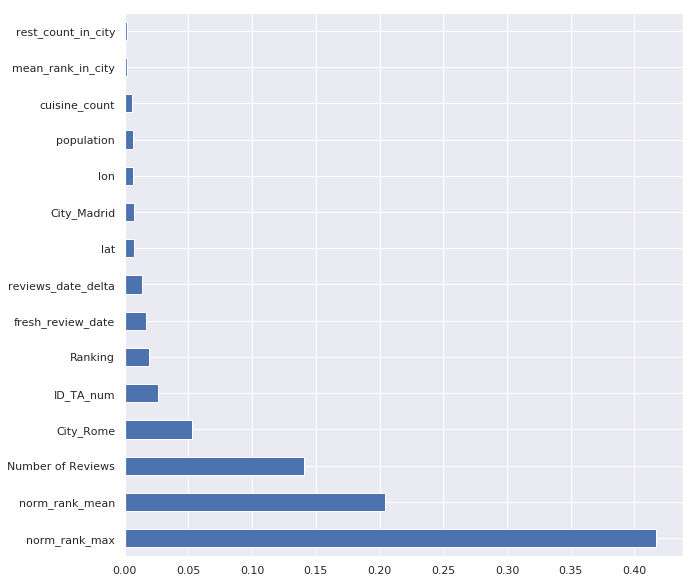

In [230]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [231]:
feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns).reset_index()
feat_imp.columns = ['feat','imp']
feat_imp.sort_values('imp', ascending=True, inplace=True)
display_full(feat_imp.feat.values)

array(['Burmese', 'Native American', 'Xinjiang', 'Azerbaijani',
       'Canadian', 'Latvian', 'Salvadoran', 'Uzbek', 'Fujian', 'Chilean',
       'Welsh', 'Armenian', 'Ecuadorean', 'Minority Chinese', 'Hawaiian',
       'Egyptian', 'Mongolian', 'Singaporean', 'Filipino', 'Cambodian',
       'Romanian', 'Jamaican', 'Southwestern', 'Slovenian', 'Tibetan',
       'Central Asian', 'Australian', 'Venezuelan', 'Central American',
       'Norwegian', 'Tunisian', 'Afghani', 'Georgian', 'Croatian',
       'Israeli', 'Indonesian', 'Ukrainian', 'Caribbean', 'Persian',
       'Russian', 'Colombian', 'Kosher', 'Sri Lankan', 'Bangladeshi',
       'country_Slovenia', 'Argentinean', 'Cuban', 'Peruvian', 'Arabic',
       'City_Ljubljana', 'country_Norway', 'country_Luxembourg',
       'country_Finland', 'City_Helsinki', 'City_Oslo', 'Swedish',
       'Malaysian', 'Balti', 'Cajun & Creole', 'Latin', 'Moroccan',
       'City_Luxembourg', 'Brazilian', 'Eastern European', 'Irish',
       'Nepali', 'Taiwanes

In [232]:
#top_feat = np.percentile(feat_imp.imp, 70)
#top_feat

0.000535461991803809

In [234]:
#drop_columns = feat_imp[feat_imp.imp < top_feat].feat

# Submission
Если все устраевает - готовим Submission на кагл

In [235]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,lat,lon,population,is_capital,missed_price_range,rest_count_in_city,...,Asian_national,Bar_right,European_right,European_national,Fast,Healthy_right,Midle_eastern,Seafood_right,Specific,unknown_right
2875,300.0,1,89.0,0.0,41.157944,-8.629105,231962,0,0,642,...,0,0,1,1,0,0,0,0,0,0
7760,1579.0,2,10.0,0.0,47.376888,8.541694,428737,0,1,685,...,0,1,0,0,0,0,0,0,0,0
3572,1016.0,1,3.0,0.0,53.349804,-6.260310,554554,1,0,836,...,0,0,0,1,0,0,0,0,0,0
2006,277.0,2,130.0,0.0,45.764042,4.835659,515695,0,1,1126,...,0,0,0,0,0,0,0,0,0,1
9994,813.0,2,119.0,0.0,38.722252,-9.139337,506654,1,0,1647,...,0,0,1,1,0,0,0,1,0,0
4565,580.0,1,98.0,0.0,41.902782,12.496365,2856133,1,0,2589,...,0,0,1,1,0,1,0,1,0,0
2625,6048.0,1,46.0,0.0,41.385063,2.173404,1620343,0,0,3395,...,0,0,1,1,0,0,0,1,0,0
9785,2098.0,1,65.0,0.0,50.850346,4.351721,1211035,1,0,1314,...,0,0,0,0,0,0,0,0,1,0
6732,659.0,2,6.0,0.0,47.376888,8.541694,428737,0,1,685,...,0,0,0,0,0,0,0,0,0,1
3745,8644.0,2,6.0,0.0,48.856613,2.352222,2175601,1,1,6108,...,0,0,0,0,0,0,0,0,0,1


In [236]:
test_data = test_data.drop(['Rating'], axis=1)

In [237]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [238]:
predict_submission = model.predict(test_data)
predict_submission = np.array(pd.Series(predict_submission).apply(r_half))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [239]:
predict_submission

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [240]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


In [241]:
sample_submission.Rating.value_counts()

4.0    3742
4.5    2834
3.5    1626
3.0     730
5.0     707
2.5     198
2.0      91
1.0      45
1.5      27
Name: Rating, dtype: int64

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
